In [40]:
import numpy as np
from ikpy.chain import Chain
from ikpy.link import URDFLink
from scipy.spatial.transform import Rotation as R
from ikpy.utils import geometry

joint_limits_min = np.array([-166, -101, -166, -176, -166, -1, -166])
joint_limits_max = np.array([166, 101, 166, -4, 166, 215, 166])
lims_min_safe = joint_limits_min + 1
lims_max_safe = joint_limits_max -1
joint_limits_rad_min = np.radians(lims_min_safe) 
joint_limits_rad_max = np.radians(lims_max_safe) 

franka_chain = Chain.from_urdf_file(
    "franka.urdf",
    base_elements=["panda_panda_link0"],
    last_link_vector=np.array([0, 0, 0.045]),
    active_links_mask = [False, True, True, True, True, True, True, True, False, False, False, False]
)
#set bounds
for i in range(len(joint_limits_rad_min)):
    franka_chain.links[i + 1].bounds = (joint_limits_rad_min[i], joint_limits_rad_max[i])

# positions = load_waypoints()
# anglelist = []
# prev_angle =  [-0.53245615, -0.38066329, 0.26839613, -0.88636377, 0.77729231, 0.09430391, 0.00391651, 0.79768890]
# for target_position in positions:
#     r = R.from_euler('xyz', [np.pi, 0, 180])  # 180° um X = Z zeigt nach unten
    
#     # # Zielmatrix bauen
#     target_frame = np.eye(4)
#     #target_frame[:3, :3] = r.as_matrix()
#     target_frame[:3, 3] = target_position

#     # Expand 7 DOF angle list to full joint vector
#     full_prev_angle = franka_chain.active_to_full(prev_angle, np.zeros(len(franka_chain.links)))
    
#     # Run IK
#     angles = franka_chain.inverse_kinematics_frame(target_frame, initial_position=full_prev_angle)
#     target_o = [0, 0, -1]
#     target_p = target_position
#     #angles = franka_chain.inverse_kinematics(target_p, target_o, orientation_mode = "Z",initial_position=full_prev_angle)
#     # Extract only active joints for the next iteration
#     prev_angle = franka_chain.active_from_full(angles)

#     fki=franka_chain.forward_kinematics(angles)
#     anglelist.append(prev_angle)
#     inter_traj = interpolate_trajectory(anglelist)
#     np.save("joint_angles.npy", inter_traj)

# for row in anglelist:
#     print("            [" + ", ".join(f"{float(v):.8f}" for v in row) + "],")
# print("")
# for row in inter_traj:
#     print("            [" + ", ".join(f"{float(v):.8f}" for v in row) + "],")

# print(fki)

In [52]:
class ValidityChecker(ob.StateValidityChecker):
    def __init__(self, si, min_distance):
        super(ValidityChecker, self).__init__(si)
        self.min_distance = min_distance
    # Returns whether the given state's position overlaps the
    # circular obstacle
    def isValid(self, state):
        #return self.clearance(state) > self.min_distance
        return True
    # Returns the distance from the given state's position to the
    # boundary of the circular obstacle.
    def clearance(self, state):
        # Extract the robot's (x,y) position from its state
        print("hallo")
        x = state[0]
        y = state[1]
        z = state[2]

  
        

        # Distance formula between three points, offset by the circle's
        # radius
        return sqrt((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2) - 0.05

    def checkCollisions(self, state):
        pass

## Returns a structure representing the optimization objective to use
#  for optimal motion planning. This method returns an objective
#  which attempts to minimize the length in configuration space of
#  computed paths.
def getPathLengthObjective(si):
    return ob.PathLengthOptimizationObjective(si)

## Returns an optimization objective which attempts to minimize path
#  length that is satisfied when a path of length shorter than 1.51
#  is found.
def getThresholdPathLengthObj(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostThreshold(ob.Cost(1.51))
    return obj

## Defines an optimization objective which attempts to steer the
#  robot away from obstacles. To formulate this objective as a
#  minimization of path cost, we can define the cost of a path as a
#  summation of the costs of each of the states along the path, where
#  each state cost is a function of that state's clearance from
#  obstacles.
#
#  The class StateCostIntegralObjective represents objectives as
#  summations of state costs, just like we require. All we need to do
#  then is inherit from that base class and define our specific state
#  cost function by overriding the stateCost() method.
#
class ClearanceObjective(ob.StateCostIntegralObjective):
    def __init__(self, si):
        super(ClearanceObjective, self).__init__(si, True)
        self.si_ = si

    # Our requirement is to maximize path clearance from obstacles,
    # but we want to represent the objective as a path cost
    # minimization. Therefore, we set each state's cost to be the
    # reciprocal of its clearance, so that as state clearance
    # increases, the state cost decreases.
    def stateCost(self, s):
        return ob.Cost(1 / (self.si_.getStateValidityChecker().clearance(s) +
                            sys.float_info.min))

## Return an optimization objective which attempts to steer the robot
#  away from obstacles.
def getClearanceObjective(si):
    return ClearanceObjective(si)

## Create an optimization objective which attempts to optimize both
#  path length and clearance. We do this by defining our individual
#  objectives, then adding them to a MultiOptimizationObjective
#  object. This results in an optimization objective where path cost
#  is equivalent to adding up each of the individual objectives' path
#  costs.
#
#  When adding objectives, we can also optionally specify each
#  objective's weighting factor to signify how important it is in
#  optimal planning. If no weight is specified, the weight defaults to
#  1.0.
def getBalancedObjective1(si):
    lengthObj = ob.PathLengthOptimizationObjective(si)
    clearObj = ClearanceObjective(si)

    opt = ob.MultiOptimizationObjective(si)
    opt.addObjective(lengthObj, 5.0)
    opt.addObjective(clearObj, 1.0)

    return opt

## Create an optimization objective equivalent to the one returned by
#  getBalancedObjective1(), but use an alternate syntax.
#  THIS DOESN'T WORK YET. THE OPERATORS SOMEHOW AREN'T EXPORTED BY Py++.
# def getBalancedObjective2(si):
#     lengthObj = ob.PathLengthOptimizationObjective(si)
#     clearObj = ClearanceObjective(si)
#
#     return 5.0*lengthObj + clearObj


## Create an optimization objective for minimizing path length, and
#  specify a cost-to-go heuristic suitable for this optimal planning
#  problem.
def getPathLengthObjWithCostToGo(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostToGoHeuristic(ob.CostToGoHeuristic(ob.goalRegionCostToGo))
    return obj


# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")


# Keep these in alphabetical order and all lower case
def allocateObjective(si, objectiveType):
    if objectiveType.lower() == "pathclearance":
        return getClearanceObjective(si)
    elif objectiveType.lower() == "pathlength":
        return getPathLengthObjective(si)
    elif objectiveType.lower() == "thresholdpathlength":
        return getThresholdPathLengthObj(si)
    elif objectiveType.lower() == "weightedlengthandclearancecombo":
        return getBalancedObjective1(si)
    else:
        ou.OMPL_ERROR("Optimization-objective is not implemented in allocation function.")



def plan(runTime, plannerType, objectiveType, fname, interpolationnumber, min_distance, start, goal):
    # Construct the robot state space in which we're planning. We're
    # planning in [0,1]x[0,1]x[0,1], a subset of R^3.


    # Construct a space information instance for this state space
    si = ob.SpaceInformation(space)

    # Set the object used to check which states in the space are valid
    validityChecker = ValidityChecker(si, min_distance)
    si.setStateValidityChecker(validityChecker)

    si.setup()
    

    # Create a problem instance
    pdef = ob.ProblemDefinition(si)

    # Set the start and goal states
    pdef.setStartAndGoalStates(start, goal)

    # Create the optimization objective specified by our command-line argument.
    # This helper function is simply a switch statement.
    pdef.setOptimizationObjective(allocateObjective(si, objectiveType))

    # Construct the optimal planner specified by our command line argument.
    # This helper function is simply a switch statement.
    optimizingPlanner = allocatePlanner(si, plannerType)

    # Set the problem instance for our planner to solve
    optimizingPlanner.setProblemDefinition(pdef)
    optimizingPlanner.setup()

    # attempt to solve the planning problem in the given runtime
    solved = optimizingPlanner.solve(runTime)

    if solved:
        path = pdef.getSolutionPath()
        path.interpolate(interpolationnumber)
        
        # Output the length of the path found
        print('{0} found solution of path length {1:.4f} with an optimization ' \
            'objective value of {2:.4f}'.format( \
            optimizingPlanner.getName(), \
            pdef.getSolutionPath().length(), \
            pdef.getSolutionPath().cost(pdef.getOptimizationObjective()).value()))

        # If a filename was specified, output the path as a matrix to
        # that file for visualization
        if fname:
            with open(fname, 'w') as outFile:
                outFile.write(pdef.getSolutionPath().printAsMatrix())
        
        path_states = pdef.getSolutionPath().getStates()
        points = [[s[i] for i in range(7)] for s in path_states]

        return points
    else:
        print("No solution found.")

if __name__ == "__main__":
    runtime = 2.0
    plannerType = "RRTstar"
    objectiveType = "PathLength"
    filename = "output.txt" # oder z.B. "path_output.txt"
    interpolationnumber = 20
    min_distance = 0.01

    space = ob.RealVectorStateSpace(7)
    
    bounds = ob.RealVectorBounds(7)
    # Set each dimension's lower and upper bounds
    for i in range(7):
        bounds.setLow(i, joint_limits_rad_min[i])
        bounds.setHigh(i, joint_limits_rad_max[i])

    space.setBounds(bounds)
    
    start_p = [0.1, 0.1, 0.85]
    start_o = [0, 0, -1]
    prev_angle =  [1, -0.38066329, 0.26839613, -2, 0.77729231, 0.09430391, 0.00391651, 0.79768890]
    full_prev_angle = franka_chain.active_to_full(prev_angle, np.zeros(len(franka_chain.links)))
    #joints_start = franka_chain.inverse_kinematics(start_p, initial_position=full_prev_angle)

    quaternation = [ 6.123234e-17,  6.123234e-17,  1.000000e+00, -6.123234e-17]
    rotation_matrix = R.from_quat(quaternation).as_matrix()
    
    start_frame = np.eye(4)
    start_frame[:3, 3] = start_p
    start_frame[:3, :3] = rotation_matrix
    joints_start = franka_chain.inverse_kinematics_frame(start_frame, initial_position=full_prev_angle)
    
    #setzen des Starts
    start = ob.State(space)
    for i in range(7):
        start[i] = joints_start[i+1]

    # 1. Start position for the robot joints
    # 2. Inverse kinematics of the goal pose 
    # 3. End position for the robot joints
    # 4. Ask OMPL what is the way to get from J[initial] -> J[goal]
        # 4.1. Make sure that does not collide against the objects in the environment


    # Set our robot's goal state to be the top-right corner of the
    # environment, or (1,1).

    # Goal from cube into joint space (inverse kinematics)
    
    goal_p = [0.65, 0.3, 0.4]
    goal_o = [0, 0, -1]

    # quaternation = [ 6.123234e-17,  6.123234e-17,  1.000000e+00, -6.123234e-17]
    # rotation_matrix = R.from_quat(quaternation).as_matrix()

    rot = R.from_euler('x', 180, degrees=True)
    rotation_matrix = rot.as_matrix()
    
    # Ziel-Homogenmatrix (4x4) bauen
    target_frame = np.eye(4)
    target_frame[:3, :3] = rotation_matrix
    target_frame[:3, 3] = goal_p
    joints_goal = franka_chain.inverse_kinematics_frame(target_frame, initial_position=full_prev_angle, orientation_mode="all")
    full_prev_angle = franka_chain.active_to_full(prev_angle, np.zeros(len(franka_chain.links)))
    #joints_goal = franka_chain.inverse_kinematics(goal_p, goal_o, initial_position=full_prev_angle)
    
    goal = ob.State(space)
    for i in range(7):
        goal[i] = joints_goal[i+1]
    
    fks=franka_chain.forward_kinematics(joints_start)
    fkg=franka_chain.forward_kinematics(joints_goal)

    print(fks, fkg)

    points = plan(runtime, plannerType, objectiveType, filename, interpolationnumber, min_distance, start, goal)
    np.save("ompl_angles.npy", points)
    print(points)
## @endcond

[[ 0.04695359  0.66575746 -0.74468944  0.1       ]
 [ 0.8622485   0.34936673  0.36670208  0.1       ]
 [ 0.50430436 -0.65932533 -0.55764435  0.84999998]
 [ 0.          0.          0.          1.        ]] [[ 1.00000000e+00  2.12194754e-11 -2.32159256e-12  6.50000000e-01]
 [ 2.12198515e-11 -1.00000000e+00 -5.94737706e-13  3.00000000e-01]
 [-2.32195340e-12  5.95051453e-13 -1.00000000e+00  4.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Debug:   RRTstar: Planner range detected to be 2.589438
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 607
Info:    RRTstar: Found an initial solution with a cost of 2.05 in 39 iterations (40 vertices in the graph)
RRTstar found solution of path length 2.0526 with an optimization objective value of 2.0526Info:    RRTstar: Created 1515 new states. Checked 1148370 rewire options. 1 goal states in tree. Final solution cost 2.053

[[0.485

In [4]:
import numpy as np

def load_waypoints():
    # Wegpunkte aus Datei laden
    waypoints = []
    with open("output.txt", "r") as f:
        for line in f:
            if line.strip():
                x, y, z = map(float, line.strip().split())
                waypoints.append(np.array([x, y, z]))
    return waypoints
    print(waypoints)
print(load_waypoints())

[array([0.1 , 0.1 , 0.85]), array([0.125145, 0.108689, 0.825019]), array([0.150289, 0.117378, 0.800038]), array([0.175434, 0.126066, 0.775056]), array([0.200579, 0.134755, 0.750075]), array([0.225724, 0.143444, 0.725094]), array([0.250868, 0.152133, 0.700113]), array([0.281571, 0.163507, 0.677027]), array([0.312273, 0.174882, 0.653941]), array([0.342976, 0.186256, 0.630856]), array([0.373678, 0.19763 , 0.60777 ]), array([0.40438 , 0.209005, 0.584685]), array([0.435083, 0.220379, 0.561599]), array([0.465785, 0.231754, 0.538513]), array([0.496488, 0.243128, 0.515428]), array([0.52719 , 0.254502, 0.492342]), array([0.557893, 0.265877, 0.469257]), array([0.588595, 0.277251, 0.446171]), array([0.619298, 0.288626, 0.423086]), array([0.65, 0.3 , 0.4 ])]


In [11]:
def interpolate_trajectory(anglelist, steps_per_segment=20):
    interpolated = []
    for i in range(len(anglelist) - 1):
        start = np.array(anglelist[i])
        end = np.array(anglelist[i + 1])
        segment = np.linspace(start, end, steps_per_segment, endpoint=False)
        interpolated.extend(segment)
    interpolated.append(anglelist[-1])  # letzter Punkt anhängen
    return np.array(interpolated)


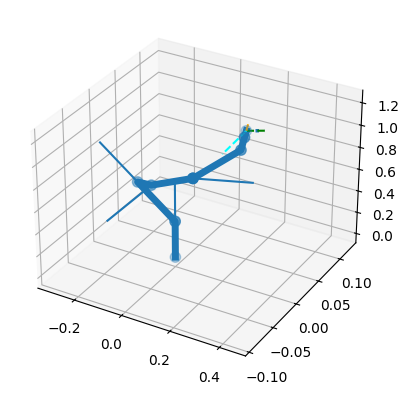

In [16]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
ax = matplotlib.pyplot.figure().add_subplot(111, projection='3d')

franka_chain.plot(joints_start, ax)
matplotlib.pyplot.show()

In [7]:
# objekte in simulation/ andere objekte in pfadplanung
# mehr Pfadpunkte kalkulieren
# TCP nach unten gerichtet
# Kolision von Roboter vermeiden
# pick and place komplett modellieren
# statt txt export mit Api arbeiten


In [8]:
import numpy as np
from ikpy.chain import Chain
from ikpy.link import URDFLink

joint_limits_min = np.array([-166, -101, -166, -176, -166, -1, -166])
joint_limits_max = np.array([166, 101, 166, -4, 166, 215, 166])

joint_limits_rad_min = np.radians(joint_limits_min) 
joint_limits_rad_max = np.radians(joint_limits_max) 

panda_chain = Chain(name='panda_arm', links=[
    URDFLink(
        name="link1",
        bounds=(joint_limits_rad_min[0],joint_limits_rad_max[0]),
        origin_translation=np.array([0.0, 0.0, 0.333]),
        origin_orientation=np.array([0.0, -1.5707963, 0.0]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link2",
        bounds=(joint_limits_rad_min[1],joint_limits_rad_max[1]),
        origin_translation=np.array([0.0000003, 0.0000001, 0.0]),
        origin_orientation=np.array([0.0, 0.0, 1.5707964]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link3",
        bounds=(joint_limits_rad_min[2],joint_limits_rad_max[2]),
        origin_translation=np.array([-0.0000001, -0.3159997, 0.0]),
        origin_orientation=np.array([-0.0000002, -0.0000002, -1.5707958]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link4",
        bounds=(joint_limits_rad_min[3],joint_limits_rad_max[3]),
        origin_translation=np.array([0.0, -0.0000001, -0.0824999]),
        origin_orientation=np.array([-0.0000002, 0.0000002, -1.5707968]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link5",
        bounds=(joint_limits_rad_min[4],joint_limits_rad_max[4]),
        origin_translation=np.array([0.0000005, 0.3839998, 0.0824996]),
        origin_orientation=np.array([-0.0000003, 0.0000001, 1.5707946]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link6",
        bounds=(joint_limits_rad_min[5],joint_limits_rad_max[5]),
        origin_translation=np.array([0.0000005, 0.0000003, 0.0000002]),
        origin_orientation=np.array([0.0000001, 0.0000003, -1.5707946]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link7",
        bounds=(joint_limits_rad_min[6],joint_limits_rad_max[6]),
        origin_translation=np.array([-0.0000002, -0.0000005, -0.0879998]),
        origin_orientation=np.array([0.0, 0.0, -1.5707996]),
        rotation=np.array([1, 0, 0]),
    ),
])

positions = load_waypoints()
anglelist = []
prev_angle = [0.09519244, -0.86469131, -0.00999133, -1.47917473, 0.00002117, 0.48928735, 0.00000000]
for target_position in positions:
    
    R = np.array([
        [1,  0,  0],
        [0,  0,  1],
        [0, -1,  0]
    ])
    target_frame = np.eye(4)
    target_frame[:3, :3] = R
    target_frame[:3, 3] = target_position
    angles = panda_chain.inverse_kinematics_frame(target_frame, initial_position=prev_angle)
    prev_angle = angles
    # joint_limits_min = np.array([-166, -101, -166, -176, -166, -1, -166])
    # joint_limits_max = np.array([166, 101, 166, -4, 166, 215, 166])
    # # Sicherheitsmarge in Grad
    # safety_margin_deg = 2.0
    # safety_margin_rad = np.radians(safety_margin_deg)
    
    # joint_limits_rad_min = np.radians(joint_limits_min) + safety_margin_rad
    # joint_limits_rad_max = np.radians(joint_limits_max) - safety_margin_rad
    
    # # Sicherstellen, dass min < max nach Abzug/Addition der Margin
    # joint_limits_rad_min = np.minimum(joint_limits_rad_min, joint_limits_rad_max - 1e-3)
    
    # angles_clipped = np.clip(angles, joint_limits_rad_min, joint_limits_rad_max)

    # # Prüfen, ob ein Wert verändert wurde
    # if not np.allclose(angles, angles_clipped, atol=1e-6):
    #     print("Warning: Clipping occurred!")
    #     print("  Original angles: ", np.round(angles, 6))
    #     print("  Clipped angles:  ", np.round(angles_clipped, 6))
    # else:
    #     print("All joint angles within limits.")

    # print(" ") 
    forward_k=panda_chain.forward_kinematics(angles)
    anglelist.append(angles)


for row in anglelist:
    print("            [" + ", ".join(f"{float(v):.8f}" for v in row) + "],")

print(forward_k)

            [0.21762429, -0.86797501, 0.15344340, -1.74395838, 0.03579127, 0.20331196, 0.00000000],
            [0.21148953, -0.83655300, 0.16402196, -1.79972194, 0.03701346, 0.20170620, 0.00000000],
            [0.20203154, -0.79619301, 0.17701247, -1.84513652, 0.03747844, 0.20088027, 0.00000000],
            [0.20006184, -0.74619449, 0.18808742, -1.88074643, 0.03666002, 0.20247252, 0.00000000],
            [0.32632113, -0.70397687, 0.11996024, -1.94116631, 0.09336223, 0.31999126, 0.00000000],
            [0.46496240, -0.67041079, 0.00867322, -2.01084714, 0.27503409, 0.47947832, 0.00000000],
            [0.21970665, -0.62594018, 0.17022073, -2.02512960, 0.21556559, 0.52675903, 0.00000000],
            [-0.22557364, -0.63440359, 0.44636804, -2.02184886, 0.37657570, 0.50331026, 0.00000000],
            [-0.28465568, -0.56633020, 0.50864849, -2.01954096, 0.45398401, 0.52887638, 0.00000000],
            [-0.23942057, -0.50337771, 0.58681116, -2.04425511, -0.10409384, 0.76189947, 0.0000000

In [9]:
import pinocchio as pin
from example_robot_data import load

robot = load("ur5")  # Auch verfügbar: "talos", "panda", "icub", etc.
model = robot.model
data = model.createData()

q0 = robot.q0
pin.forwardKinematics(model, data, q0)
placement = data.oMi[model.getFrameId("tool0")]  # Endeffektor-Frame

print("TCP-Position:", placement.translation)


IndexError: Index out of range

In [ ]:
from ikpy.chain import Chain

franka_chain = Chain.from_urdf_file("franka.urdf")
print(franka_chain)

# Target position in Cartesian coordinates (x, y, z)
target_position = [0.5, 0.0, 0.5]

#joint_angles = franka_chain.inverse_kinematics(target_position)

#print("Joint angles for target position:", joint_angles)